# Simulating the behavior of a collective performing excavation

Ants perform excavation using location of previous excavation from memory

&copy; S Ganga Prasath -- 17 Mar, 2023

In [130]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import jax.numpy as jnp
import jax
from jax import random
from jax import jit
from jax import vmap
from jax import lax
from jax.tree_util import register_pytree_node
import time
from typing import Tuple, Iterable
from functools import partial
from typing import NamedTuple, Any

In [131]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

In [144]:
class params():
    def __init__(self) -> None:
        super().__init__()
        self.nSteps = 10
        self.nAnts = 5
        self.dr = 0.5
        self.bxSz = 5
        key = random.PRNGKey(42)
        self.rInit = random.uniform(key,
                                    minval=-self.bxSz,
                                    maxval=self.bxSz,
                                    shape=(self.nAnts,2))
        self.thetInit = random.uniform(key,
                                    minval=-jnp.pi,
                                    maxval=jnp.pi,
                                    shape=(self.nAnts,1))
        self.eps = 0.25

In [145]:
class ants():
    def __init__(self, r, thet, rng):
        super().__init__()
        self.r = r
        self.thet = thet
        self.rng = rng
    
    # @jit
    def stepFwd(self, dr, nAnts):
        drng = random.split(self.rng)[0]
        new_r = self.r + dr*jnp.hstack([jnp.cos(self.thet), jnp.sin(self.thet)])
        new_thet = self.thet + random.uniform(drng,
                                              minval=-jnp.pi/4,
                                              maxval=jnp.pi/4,
                                              shape=(nAnts,1))
        return ants(new_r, new_thet, drng)
    
    # @jit
    def homing(self, dr, new_thet):
        drng = random.split(self.rng)[0]
        new_r = self.r + dr*jnp.hstack([jnp.cos(new_thet), jnp.sin(new_thet)])  
        return ants(new_r, new_thet, drng)
    
# register_pytree_node(ants,
#                      lambda x: ((x.r[p.nAnts,0], x.r[p.nAnts,1], x.thet[p.nAnts], x.rng), None),
#                      lambda _, tup: ants(jnp.array([tup[:,0], tup[:,1]]), tup[:,2], tup[3]))

In [146]:
@jit
def angFnd(r):
    return jnp.arctan2(r[1],r[0])-jnp.pi

angFndVec = jax.vmap(angFnd)
angFndVec(p.rInit)

Array([-1.775775 , -5.5010834], dtype=float32)

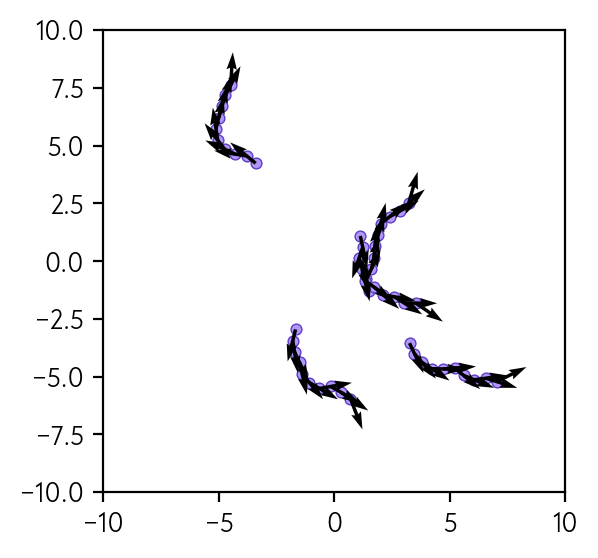

In [147]:
rng = random.PRNGKey(0)
p = params()
ag = ants(p.rInit, p.thetInit, rng)
start_time = time.time()
ind = 0

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc("font", family="Noah")
plt.rc("xtick", labelsize="medium")

linewidth = 1.2
linestyle = "-"
label_size = 15
color = colors['violet'][3]
fig = plt.figure(figsize=(3, 3), dpi=200)
nRow = 1
nCol = 1
ax1 = plt.subplot(nRow, nCol, 1, aspect=1)
while ind < p.nSteps:
    ag = ag.stepFwd(p.dr, p.nAnts)
    ax1.scatter(ag.r[:,0], ag.r[:,1],
                s=15,
                color=color,
                edgecolors=colors['violet'][9],
                linewidth=0.5,
                zorder=-1)
    ax1.quiver(ag.r[:,0],
               ag.r[:,1],
               jnp.cos(ag.thet.flatten()),
               jnp.sin(ag.thet.flatten()),
               scale_units='xy',
               scale=0.7,
               color='k')
    ind += 1
ax1.set_xlim([-10., 10.])
ax1.set_ylim([-10., 10.])
plt.show()